<a id='sec2.1'></a>
### 2.1 Predicción con Redes Neuronales Recurrentes

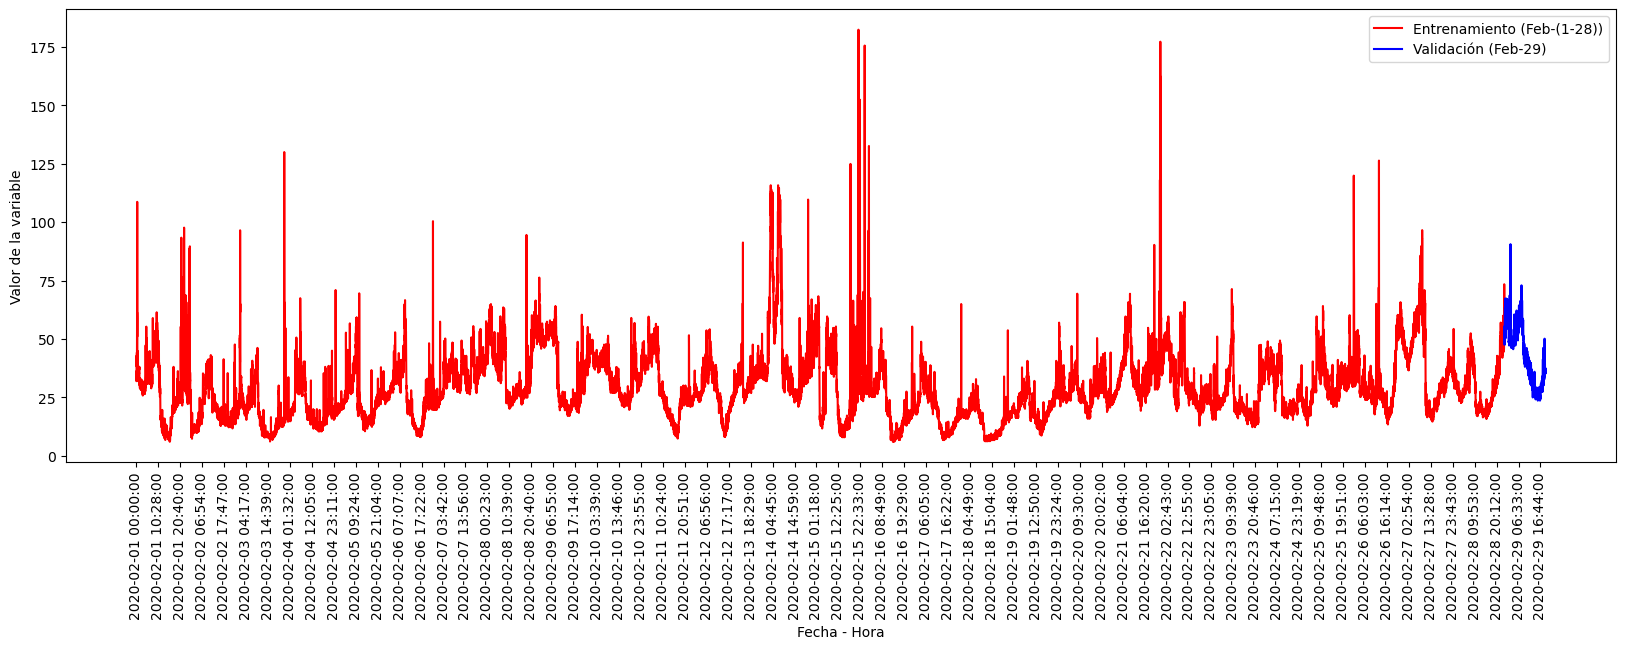

In [1]:
import numpy as np
np.random.seed(4)
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

#
# 1. LECTURA DE DATOS **********************

# 1.1 Lectura del dataframe desde archivo
#
dataset = pd.read_csv('F:\PhD\Datos SIATA\Análisis\Descriptivo\RNN\pm25_fusion.csv',sep=",")
#dataset.head()

# 1.2 Crea nueva columna con los datos de dos columnas
dataset["fechaHora"] = dataset["fecha"] + " " + dataset["hora"]

#
# Sets de entrenamiento y validación 
# La LSTM se entrenará con datos hasta el 28 de febrero. La validación se hará con datos del 29 de febrero.
# Se hará solo para le valor de df_nova
#

nodo = 2
variable = "dataFusion"

# 1.3 Construcción del set de entrenamiento extrayendo los dtaos de nodo indicado, la fecha hasta la cual 
# se tendrán en cuenta para los datos y establecimiento de la variable fechaHora como index. 
set_entrenamiento = dataset.loc[dataset.loc[:,"codigoSerial"]==nodo]
set_entrenamiento = set_entrenamiento.loc[set_entrenamiento.loc[:,"fecha"]!="2020-02-29"]
set_entrenamiento = set_entrenamiento.loc[:,["fechaHora", variable]]
pd.to_datetime(set_entrenamiento["fechaHora"])
set_entrenamiento.set_index("fechaHora", inplace=True)

# 1.4 Construcción del set de entrenamiento extrayendo los dtaos de nodo indicado, la fecha hasta la cual 
# se tendrán en cuenta para los datos y establecimiento de la variable fechaHora como index.
set_validacion = dataset.loc[dataset.loc[:,"codigoSerial"]==nodo]
set_validacion = set_validacion.loc[set_validacion.loc[:,"fecha"]=="2020-02-29"]
set_validacion = set_validacion.loc[:,["fechaHora", variable]]
pd.to_datetime(set_validacion["fechaHora"])
set_validacion.set_index("fechaHora", inplace=True)

# 1.5 Gráfico de los datos de entrenamiento y validación
plt.figure(figsize=(20, 6), dpi=100)
plt.plot(set_entrenamiento.index, set_entrenamiento[variable],color='red', label='Entrenamiento (Feb-(1-28))')
plt.plot(set_validacion.index, set_validacion[variable],color='blue', label='Validación (Feb-29)')
plt.xticks(np.arange(0, len(dataset.loc[dataset.loc[:,"codigoSerial"]==nodo].fechaHora), 600), rotation=90)
plt.xlabel('Fecha - Hora')
plt.ylabel('Valor de la variable')
plt.legend()
plt.show()

# 1.6 Normalización del set de entrenamiento, lo ques e hace es llevar los dtaos a una escala de 0 a 1.
sc = MinMaxScaler(feature_range=(0,1))
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)


Dim entrada: (60, 1)
Epoch 1/20
1168/1168 [==============================] - 45s 22ms/step - loss: 0.0011 0s - loss: 
Epoch 2/20
1168/1168 [==============================] - 25s 22ms/step - loss: 3.2685e-04
Epoch 3/20
1168/1168 [==============================] - 26s 22ms/step - loss: 3.3485e-04
Epoch 4/20
1168/1168 [==============================] - 26s 22ms/step - loss: 3.2808e-04
Epoch 5/20
1168/1168 [==============================] - 26s 22ms/step - loss: 2.7713e-04
Epoch 6/20
1168/1168 [==============================] - 25s 21ms/step - loss: 3.4650e-04
Epoch 7/20
1168/1168 [==============================] - 27s 23ms/step - loss: 3.9191e-04
Epoch 8/20
1168/1168 [==============================] - 27s 23ms/step - loss: 2.9355e-04
Epoch 9/20
1168/1168 [==============================] - 25s 21ms/step - loss: 3.4327e-04 0s - loss
Epoch 10/20
1168/1168 [==============================] - 25s 21ms/step - loss: 2.8633e-04
Epoch 11/20
1168/1168 [==============================] - 25s 21ms/step

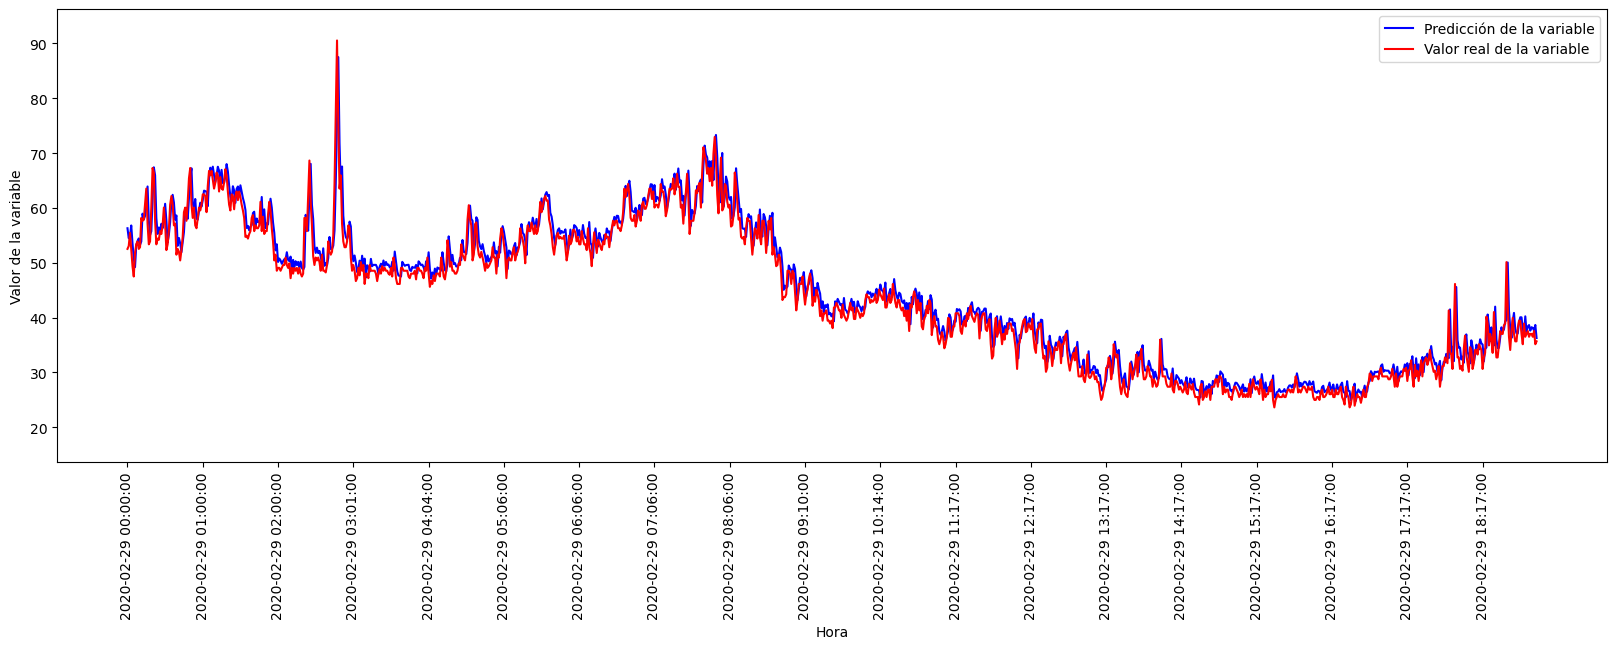

In [2]:
#
# Funciones auxiliares
#
def graficar_predicciones(real, prediccion):
    plt.figure(figsize=(20, 6), dpi=100)
    plt.plot(prediccion, color='blue', label='Predicción de la variable')
    plt.plot(real.index, real.values[0:len(prediccion)],color='red', label='Valor real de la variable')
    plt.xticks(np.arange(0, len(real.index), 60), rotation=90)
    plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
    plt.xlabel('Hora')
    plt.ylabel('Valor de la variable')
    plt.legend()
    plt.show()

# 2. RED LSTM ***************************************

# 2.1 La red LSTM tendrá como entrada "time_step" datos consecutivos, y como salida 1 dato (la predicción a
# partir de esos "time_step" datos). Se conformará de esta forma el set de entrenamiento
time_step = 60
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)

#En el código anterior usamos el bloque for para iterativamente dividir el set de entrenamiento en bloques de
# la cantidad de datos establecida en la varibale time_step y almacenar los bloques correspondientes en diferentes
# posiciones de las variables X_train y Y_train.

for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(set_entrenamiento_escalado[i-time_step:i,0])

    # Y: el siguiente dato
    Y_train.append(set_entrenamiento_escalado[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)


# 2.2 Reshape X_train para que se ajuste al modelo en Keras
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

#
# 2.3 Red LSTM: 

# 2.3.1 Para crear la red debemos primero definir el tamaño de los datos de entrada y del dato de salida, 
# así como el número total de neuronas (na):
#
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
na = 50


# 2.3.2 Creación del modelo con un contenedor usando el módulo Sequential
modelo = Sequential()

# Ahora añadimos la Red LSTM usando la función add, especificando el número 
# de neuronas a usar (parámetro units) y el tamaño de cada dato de entrada (parámetro input_shape):
modelo.add(LSTM(units=na, input_shape=dim_entrada))

# Para la capa de salida usamos la función Dense y especificamos que el dato de salida tendrá un 
# tamaño igual a 1 (parámetro units):
modelo.add(Dense(units=dim_salida))

# Ahora debemos compilar el modelo, definiendo así la función de error (parámetro loss) así como el 
# método que se usará para minimizarla (parámetro optimizer). El optimizador seleccionado (rmsprop) 
# funciona de manera similar al algoritmo del Gradiente Descendente, mientras que la función de error 
# es el error cuadrático medio,
modelo.compile(optimizer='rmsprop', loss='mse')

# El entrenamiento se implementa de forma sencilla usando la función fit. En este caso usaremos un 
# total de 20 iteraciones (parámetro epochs) y presentaremos a la Red LSTM lotes de 32 datos (parámetro batch_size):
modelo.fit(X_train,Y_train,epochs=20,batch_size=32, verbose = 0)


# 3. VALIDACIÓN DEL MODELO
#
# 3.1 Validación (predicción del valor de la variable). Inicialmente debemos preparar el set de validación, 
# normalizando inicialmente los datos, en el rango de 0 a 1, para lo cual usamos la transformación implementada 
# anteriormente sobre el set de entrenamiento:
#

x_test = np.concatenate((set_entrenamiento.tail(n=time_step).values,set_validacion.values),axis=0)
#x_test = set_validacion.values
x_test = sc.transform(x_test)

# Recordemos que el modelo fue entrenado para tomar "time_step" datos y generar un dato como predicción. Así que debemos 
# reorganizar el set de validación (x_test) para que tenga bloques de "time_step" datos:

X_test = []

for i in range(time_step,len(x_test)):
    X_test.append(x_test[i-time_step:i,0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

# 3.2 Predicción: Y finalmente realizamos la predicción usando la función predict y aplicamos la normalización inversa 
# de dicha predicción para que esté en la escala real de las acciones:

prediccion = modelo.predict(X_test)
prediccion = sc.inverse_transform(prediccion)

# 3.3 Graficar resultados
graficar_predicciones(set_validacion,prediccion)

In [7]:
set_validacion

,dataFusion
fechaHora,
2020-02-29 00:00:00,52.5338
2020-02-29 00:01:00,53.0589
2020-02-29 00:02:00,55.4677
2020-02-29 00:03:00,52.5338
2020-02-29 00:04:00,49.3832
...,...
2020-02-29 18:57:00,37.0307
2020-02-29 18:58:00,36.5056
2020-02-29 18:59:00,37.5558


In [14]:
import numpy as np
np.random.seed(4)
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

dataset = pd.read_csv("F:\PhD\Datos SIATA\Análisis\Descriptivo\datosCoordenados_CS.csv",sep=",")
dataRNN = pd.read_csv("F:\PhD\Datos SIATA\Análisis\Descriptivo\datos_corregidos_RNN.csv",sep=",")
dataTendencia = pd.read_csv("F:\PhD\Datos SIATA\Análisis\Descriptivo\datos_corregidos_CC_m-10.csv",sep=",")

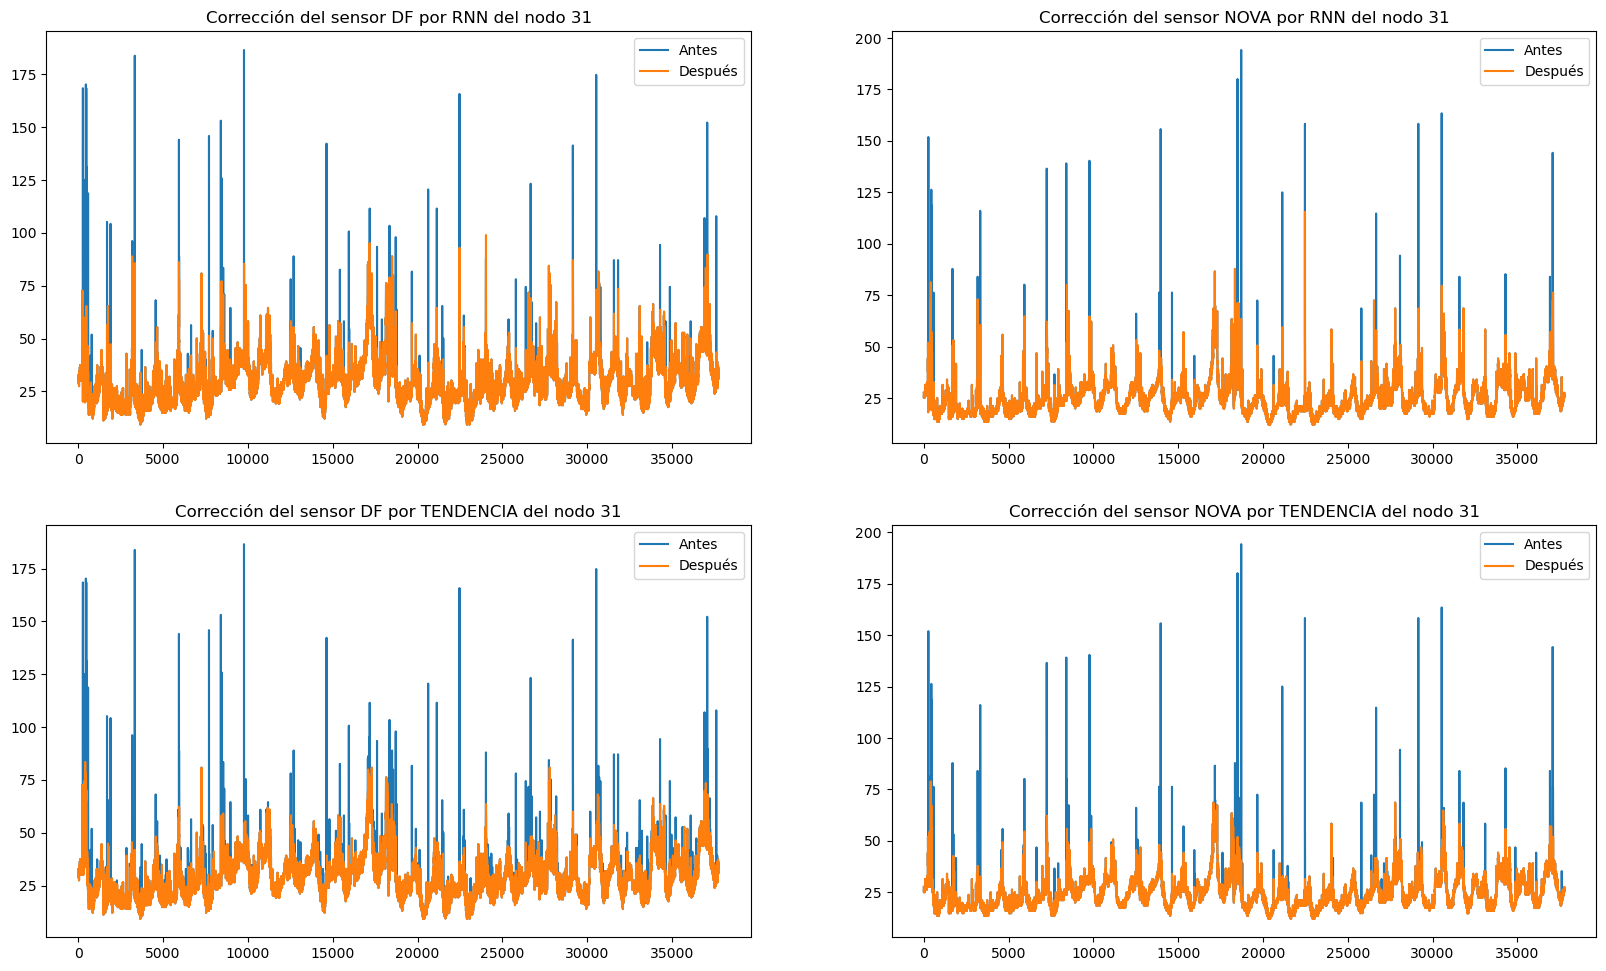

In [15]:
n = 31
no_corregidos = dataset.loc[dataset.loc[:,"codigoSerial"]== n]
corregidosRNN = dataRNN.loc[dataRNN.loc[:,"codigoSerial"]== n]
corregidosTEN = dataTendencia.loc[dataTendencia.loc[:,"codigoSerial"]== n]

fig, ([ax1, ax2],[ax3, ax4]) = plt.subplots(nrows=2, ncols=2, figsize=(20,12), dpi=100)
ax1.set_title("Corrección del sensor DF por RNN del nodo "+str(n))
ax1.plot(no_corregidos.pm25_df.tolist(), label="Antes")
ax1.plot(corregidosRNN.pm25_df.tolist(), label="Después")
ax1.legend()

ax2.set_title("Corrección del sensor NOVA por RNN del nodo "+str(n))
ax2.plot(no_corregidos.pm25_nova.tolist(), label="Antes")
ax2.plot(corregidosRNN.pm25_nova.tolist(), label="Después")
ax2.legend()

ax3.set_title("Corrección del sensor DF por TENDENCIA del nodo "+str(n))
ax3.plot(no_corregidos.pm25_df.tolist(), label="Antes")
ax3.plot(corregidosTEN.pm25_df.tolist(), label="Después")
ax3.legend()

ax4.set_title("Corrección del sensor NOVA por TENDENCIA del nodo "+str(n))
ax4.plot(no_corregidos.pm25_nova.tolist(), label="Antes")
ax4.plot(corregidosTEN.pm25_nova.tolist(), label="Después")
ax4.legend()


plt.show()